### F4 was with mistakes. F5 - full combination of yorko's and lukyanenko's kernels

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import eli5
from sklearn import decomposition
import lightgbm as lgb
import xgboost as xgb

import os
from IPython.display import display_html

import json
from tqdm import tqdm_notebook

In [13]:
df_train_pickle = pd.read_pickle("./train_features_4.pkl")
df_test_pickle = pd.read_pickle("./test_features_4.pkl")

In [14]:
PATH_TO_DATA = '../../data/dota_2/'

In [15]:
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

y = df_train_targets['radiant_win'].values

In [16]:
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

In [17]:
#df_train_features.index

In [18]:
#df_train_pickle.index = df_train_features.index
#df_test_pickle.index = df_test_features.index

In [19]:
X_train = df_train_pickle.copy()
X_test = df_test_pickle.copy()

In [20]:
def read_matches(matches_file):   # Read json file
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [21]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills

In [22]:
# copy the dataframe with features
X_train_extended = X_train.copy()

# add new features
add_new_features(X_train_extended, 
                 os.path.join(PATH_TO_DATA, 
                              'train_matches.jsonl'))

In [27]:
X_train_extended.radiant_tower_kills.unique()

array([nan,  0.,  2.,  4.,  3.,  1.,  7.,  6.,  5.,  9.,  8., 10., 11.])

In [28]:
pd.to_pickle(X_train_extended, "./train_features_tower_kills.pkl")
#pd.to_pickle(X_test, "./test_features_4.pkl")

In [33]:
X_train_extended.shape

(79350, 569)

In [34]:
X_train_extended.head(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,155.0,22.0,7.0,1.0,11.0,11.0,0.0,0.0,0.0,0.0,...,2.727974,375.188353,244.929582,1.531821,848.4,311.0,2.727974,NaN,NaN,NaN
1,658.0,4.0,0.0,3.0,10.0,15.0,7.0,2.0,0.0,7.0,...,0.866879,2286.086350,2169.544929,1.053717,4240.6,4891.8,0.866879,NaN,NaN,NaN
2,21.0,23.0,0.0,0.0,0.0,101.0,0.0,0.0,0.0,0.0,...,0.971429,30.410524,31.304952,0.971429,13.6,14.0,0.971429,NaN,NaN,NaN
3,576.0,22.0,7.0,1.0,4.0,14.0,1.0,0.0,3.0,1.0,...,0.668450,1416.962314,989.946867,1.431352,3049.2,4561.6,0.668450,NaN,NaN,NaN
4,453.0,22.0,7.0,1.0,3.0,42.0,0.0,1.0,1.0,0.0,...,1.687261,1079.992963,1121.422177,0.963057,3173.4,1880.8,1.687261,NaN,NaN,NaN


In [36]:
X_train_extended.tail(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
e2ca68ac1a6847f4a37f6c9c8ee8695b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
47ad6454ede66c1c78fdaa9391dfc556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0,3.0
9928dfde50efcbdb2055da23dcdbc101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,-2.0


In [40]:
X_train_tower_kills = X_train_extended.iloc[39675 : , -3 : ]

In [41]:
X_train_tower_kills.head(5)

,radiant_tower_kills,dire_tower_kills,diff_tower_kills
a400b8f29dece5f4d266f49f1ae2e98a,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,0.0,0.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,0.0,0.0,0.0


In [48]:
X_train_tower_kills.shape

(39675, 3)

In [49]:
X_train_extended_copy = X_train_extended.copy()

In [44]:
X_train_extended_copy.iloc[0:39676, -3:] = X_train_tower_kills

In [53]:
index_to_drop = list(X_train_extended_copy.iloc[39675:].index)
index_to_drop



['a400b8f29dece5f4d266f49f1ae2e98a',
 'b9c57c450ce74a2af79c9ce96fac144d',
 '6db558535151ea18ca70a6892197db41',
 '46a0ddce8f7ed2a8d9bd5edcbb925682',
 'b1b35ff97723d9b7ade1c9c3cf48f770',
 '19c39fe2af2b547e48708ca005c6ae74',
 'c96d629dc0c39f0c616d1949938a6ba6',
 '156c88bff4e9c4668b0f53df3d870f1b',
 'df50f738c454d430a33b2bf90cb9ef1a',
 '7469e9440ea3d19b211a484647c7126e',
 '0aa1c6d7630433a93fe42da5ac810368',
 '892b5d40992e4b334e159f99b2bb55e6',
 '44eb0c077ca68678bb9bfead29e9c455',
 'eda82a5a0ae96848e73929c643925633',
 'ab3cc6ccac661a1385e73a2e9f21313a',
 'a3c3892648b873bb869dd81ca0f62286',
 '34c81a8faede0d8f1f87dcc6ee824658',
 '5feece770ca79e5e8cd8052198b3f533',
 '54aaab1cb8cc5df3c253641618673266',
 'c95069179039952da9db7635ee22972b',
 '8f56cc2468ba5c37edb79f3a7b4af6e6',
 '171d8515f371cdf5d03c44575cee70c7',
 '44cdded6d3311134563f743eb77685b2',
 '086e5ed8fee6258a3b6ed9127f833573',
 'b6f39b49177535c9417eecd8c696674d',
 '8ca9e390d39160645953a682a8d6f225',
 '4b6e4e511d399180776d0f23984466b2',
 

In [54]:
X_train_extended_copy.drop(index_to_drop, inplace = True)


(79350, 569)

In [55]:
X_train_extended_copy.shape

(39675, 569)

In [56]:
X_train_extended_copy.tail(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
39670,1783.0,22.0,0.0,8.0,23.0,3.0,1.0,9.0,9.0,0.0,...,0.988215,3698.775568,8433.391388,0.438587,15798.2,15986.6,0.988215,NaN,NaN,NaN
39671,377.0,22.0,7.0,1.0,0.0,14.0,0.0,2.0,1.0,1.0,...,0.998376,943.429648,1094.492668,0.861979,1721.0,1723.8,0.998376,NaN,NaN,NaN
39672,643.0,22.0,7.0,1.0,23.0,63.0,1.0,4.0,0.0,2.0,...,1.655617,1064.926289,1207.448011,0.881965,5344.0,3227.8,1.655617,NaN,NaN,NaN
39673,2405.0,22.0,7.0,12.0,4.0,22.0,3.0,8.0,14.0,7.0,...,1.019466,11343.984252,8465.262359,1.340063,26688.2,26178.6,1.019466,NaN,NaN,NaN
39674,1775.0,22.0,0.0,10.0,13.0,32.0,3.0,4.0,15.0,0.0,...,0.833997,6080.977249,4735.316853,1.284175,12647.4,15164.8,0.833997,NaN,NaN,NaN


In [57]:
X_train_extended_copy.iloc[:,-3:] = X_train_tower_kills.values
X_train_extended_copy.tail(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
39670,1783.0,22.0,0.0,8.0,23.0,3.0,1.0,9.0,9.0,0.0,...,0.988215,3698.775568,8433.391388,0.438587,15798.2,15986.6,0.988215,3.0,4.0,-1.0
39671,377.0,22.0,7.0,1.0,0.0,14.0,0.0,2.0,1.0,1.0,...,0.998376,943.429648,1094.492668,0.861979,1721.0,1723.8,0.998376,0.0,0.0,0.0
39672,643.0,22.0,7.0,1.0,23.0,63.0,1.0,4.0,0.0,2.0,...,1.655617,1064.926289,1207.448011,0.881965,5344.0,3227.8,1.655617,0.0,0.0,0.0
39673,2405.0,22.0,7.0,12.0,4.0,22.0,3.0,8.0,14.0,7.0,...,1.019466,11343.984252,8465.262359,1.340063,26688.2,26178.6,1.019466,6.0,3.0,3.0
39674,1775.0,22.0,0.0,10.0,13.0,32.0,3.0,4.0,15.0,0.0,...,0.833997,6080.977249,4735.316853,1.284175,12647.4,15164.8,0.833997,3.0,5.0,-2.0


In [81]:
X_train_f5 = X_train_extended_copy.copy()
pd.to_pickle(X_train_f5, "./train_features_5.pkl")

In [82]:
X_train_extended_copy.shape

(39675, 569)

In [83]:
X_train_f5.shape

(39675, 569)

In [29]:
X_test_extended = X_test.copy()

add_new_features(X_test_extended, 
                 os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))

In [30]:
X_train_extended.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,155.0,22.0,7.0,1.0,11.0,11.0,0.0,0.0,0.0,0.0,...,2.727974,375.188353,244.929582,1.531821,848.4,311.0,2.727974,NaN,NaN,NaN
1,658.0,4.0,0.0,3.0,10.0,15.0,7.0,2.0,0.0,7.0,...,0.866879,2286.086350,2169.544929,1.053717,4240.6,4891.8,0.866879,NaN,NaN,NaN
2,21.0,23.0,0.0,0.0,0.0,101.0,0.0,0.0,0.0,0.0,...,0.971429,30.410524,31.304952,0.971429,13.6,14.0,0.971429,NaN,NaN,NaN


In [31]:
X_test_extended.fillna(0)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,23.0,4.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0,0.0,...,0.390821,50.415275,194.104869,0.259732,56.2,143.8,0.390821,0.0,0.0,0.0
1,1044.0,22.0,7.0,12.0,6.0,23.0,3.0,5.0,7.0,1.0,...,1.045873,2383.984480,2904.398389,0.820819,10328.0,9875.0,1.045873,0.0,0.0,0.0
2,1091.0,22.0,7.0,6.0,1.0,64.0,3.0,1.0,7.0,1.0,...,0.809324,3028.941284,2068.178716,1.464545,7374.4,9111.8,0.809324,0.0,0.0,0.0
3,623.0,22.0,7.0,1.0,0.0,41.0,0.0,0.0,1.0,2.0,...,0.785550,1394.561759,2207.179580,0.631830,4025.0,5123.8,0.785550,0.0,0.0,0.0
4,1538.0,22.0,7.0,7.0,11.0,40.0,2.0,7.0,12.0,0.0,...,1.098725,4889.783104,7536.599319,0.648805,14258.6,12977.4,1.098725,0.0,0.0,0.0
5,1989.0,22.0,7.0,12.0,4.0,41.0,7.0,10.0,8.0,47.0,...,1.569142,6611.709991,3494.447911,1.892061,20863.0,13295.8,1.569142,0.0,0.0,0.0
6,1114.0,22.0,7.0,9.0,6.0,9.0,8.0,2.0,10.0,0.0,...,0.688334,2090.155138,4053.676171,0.515620,7688.0,11169.0,0.688334,0.0,0.0,0.0
7,1631.0,22.0,7.0,14.0,5.0,99.0,3.0,7.0,3.0,1.0,...,0.545545,2286.656183,21461.257924,0.106548,11590.0,21244.8,0.545545,0.0,0.0,0.0
8,1066.0,22.0,0.0,3.0,7.0,104.0,1.0,0.0,1.0,0.0,...,2.033379,4097.816394,2057.257714,1.991883,10904.2,5362.6,2.033379,0.0,0.0,0.0
9,1675.0,22.0,7.0,11.0,18.0,20.0,2.0,7.0,8.0,3.0,...,0.832335,1960.186343,3009.034363,0.651434,12234.0,14698.4,0.832335,0.0,0.0,0.0


In [32]:
X_test_extended.shape

(20000, 569)

In [61]:
X_test_extended.iloc[:10000, -3:] = X_test_extended.iloc[10000:, -3:].values

In [62]:
X_test_extended.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,23.0,4.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0,0.0,...,0.390821,50.415275,194.104869,0.259732,56.2,143.8,0.390821,0.0,0.0,0.0
1,1044.0,22.0,7.0,12.0,6.0,23.0,3.0,5.0,7.0,1.0,...,1.045873,2383.984480,2904.398389,0.820819,10328.0,9875.0,1.045873,7.0,2.0,5.0
2,1091.0,22.0,7.0,6.0,1.0,64.0,3.0,1.0,7.0,1.0,...,0.809324,3028.941284,2068.178716,1.464545,7374.4,9111.8,0.809324,4.0,1.0,3.0


In [64]:
test_index_to_drop = list(X_test_extended.index)[10000:]

In [67]:
np.shape(test_index_to_drop)

(10000,)

In [68]:
X_test_extended.drop(test_index_to_drop, inplace = True)
X_test_extended.shape

(10000, 569)

In [70]:
X_test_extended.tail(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
9997,391.0,22.0,7.0,1.0,0.0,21.0,0.0,1.0,0.0,8.0,...,1.006902,892.624109,148.948649,5.992831,2392.6,2376.2,1.006902,0.0,0.0,0.0
9998,1254.0,22.0,7.0,7.0,3.0,90.0,0.0,4.0,6.0,0.0,...,0.674074,2632.616721,3502.901112,0.751553,7213.4,10701.2,0.674074,4.0,0.0,4.0
9999,1553.0,22.0,7.0,9.0,12.0,14.0,5.0,7.0,4.0,5.0,...,1.249361,8366.343478,10165.149000,0.823042,20138.2,16118.8,1.249361,2.0,6.0,-4.0


In [71]:
pd.to_pickle(X_test_extended, "./test_features_5.pkl")

In [72]:
X_test_extended.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,23.0,4.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0,0.0,...,0.390821,50.415275,194.104869,0.259732,56.2,143.8,0.390821,0.0,0.0,0.0
1,1044.0,22.0,7.0,12.0,6.0,23.0,3.0,5.0,7.0,1.0,...,1.045873,2383.984480,2904.398389,0.820819,10328.0,9875.0,1.045873,7.0,2.0,5.0
2,1091.0,22.0,7.0,6.0,1.0,64.0,3.0,1.0,7.0,1.0,...,0.809324,3028.941284,2068.178716,1.464545,7374.4,9111.8,0.809324,4.0,1.0,3.0


In [73]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [74]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [84]:
X_train_f5.shape

(39675, 569)

In [85]:
X_test_extended.shape

(10000, 569)

In [86]:
y.shape

(39675,)

Fold 0 started at Sun Nov 17 13:45:11 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.891191	valid_1's auc: 0.826119
Early stopping, best iteration is:
[1739]	training's auc: 0.929433	valid_1's auc: 0.827435
Fold 1 started at Sun Nov 17 13:45:41 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.892464	valid_1's auc: 0.814968
[2000]	training's auc: 0.9404	valid_1's auc: 0.817262
Early stopping, best iteration is:
[2452]	training's auc: 0.955852	valid_1's auc: 0.818
Fold 2 started at Sun Nov 17 13:46:18 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.890301	valid_1's auc: 0.828853
[2000]	training's auc: 0.93923	valid_1's auc: 0.831079
Early stopping, best iteration is:
[1912]	training's auc: 0.935732	valid_1's auc: 0.831131
Fold 3 started at Sun Nov 17 13:46:49 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.889908	v

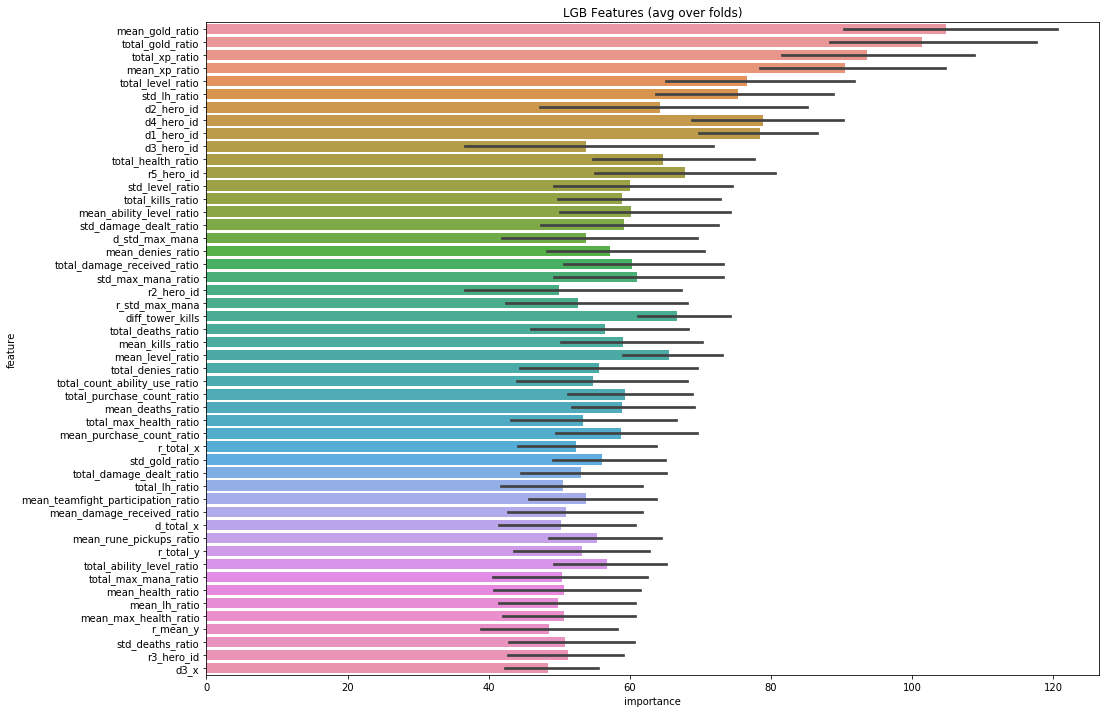

In [88]:
import time
oof_lgb, prediction_lgb, scores = train_model(X_train_f5, X_test_extended, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)

In [89]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

In [90]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': prediction_lgb}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f5.csv')